<a href="https://colab.research.google.com/github/fmigas/Projects/blob/main/Ukraine_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are are couple of reasons why I decided to set up my own project rather than use a public dataset or join a kaggle competition:


*   I decided to define a problem myself
*   I needed to collect data myself
*   I could not follow any other kaggle notebooks to find the best solution ;-)
*   I needed to make my own decisions on all key factors, like project goal and metrics
*   I had no clear benchmark to find out "what is a good result"

In other words, it looks more like a "real world" project than an artificial kaggle competition, whare data, objectives, metrics and benchmarks are defined.



**Problem definition:** take a collection of tweets on Ukraine and find out, which of them come from an "expert".

The measure of "being an expert" is here a number of followers. I'll discuss further what threshold (a thousand of followers? ten thousand?) I decided to pick.

I am aware this problem may seem trivial and a bit unrealistic, but the big advantage is that I did not have to care about labelled data. When parsing tweets, we can easily get a number of the user's followers.

**First step - data collection**

I used snscrape module to download 100.000 tweets containing a word "Ukraine", all written in English.
I downloaded 4.000 tweets each day from 2nd of October through 27 of October.

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

tweets_list = []
for n in range(2, 27):
    date = '2022-09-' + str(n)
    query = 'Ukraine lang:en until:' + date
    print(query)
    # Using TwitterSearchScraper to scrape data and append tweets to list
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
        if i >= 4000:
            break
        tweets_list.append([tweet.date, tweet.content, tweet.user.username, tweet.user.followersCount])

# Creating a dataframe from the tweets list above
df = pd.DataFrame(tweets_list, columns = ['Date', 'Text', 'Username', 'followersCount'])

**Raw ideas**

Before EDA and data processing, let's ask a couple of questions and extract a couple of features from the raw text.

What text features may make difference between an "expert opinion/message" and a "non-expert comment"?
* Maybe "expert" messages are longer?
* Or maybe they are use slightly different vocabulary?
* Or maybe "non-experts" abuse dirty words in their comments?
* Or maybe "experts" include more hashes or links in their messages?
* Or should we dig deeper into Natural Language Understanding tools, like contextual embeddings from the state-of-the-art transformer models like BERT?





**"Expert" definition**
My initial notion was to define an "expert" as a Twitter use with at least 10.000 followers.

At the end, we'll check alternative thresholds (from 1.000 to 10.000, with a 1.000 step) and we'll observe how a modified definition affects the results.

**Feature extraction**
Before we clean and tokenize tweets, let's extract a couple of features:
* tweet length
* '#' count in a tweet
* @ count in a tweet
* dirty words count in a tweet
* links count in a tweet

Let's start with loading a raw file from the repository.

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/drive/MyDrive/Python_data/tweets.csv")
df.drop(['Unnamed: 0'], inplace = True, axis = 1)
df.isna().sum()
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.columns = 'date text user num'.split()
df.num = df.num.astype('int32')


df['at'] = df['text'].apply(lambda x: x.count('@'))
df['hash'] = df['text'].apply(lambda x: x.count('#'))
df['len'] = df['text'].apply(lambda x: len(x))
df['links'] = df['text'].apply(lambda x: x.count('http'))
df['expert'] = df['num'].apply(lambda x: 1 if x > 10000 else 0)

We added 'at', 'hash', 'len', 'links' columns and an 'expert' column mapped intuitively: expert: 1, non-expert: 0.


In [ ]:
df.head()

,date,text,user,num,at,hash,len,links,expert
0,2022-09-01 23:59:54+00:00,@SenatorWicker @CNN @jimsciutto Please send 20...,ArtemiyMoroz,105,3,1,80,0,0
1,2022-09-01 23:59:47+00:00,"@Der_Parrot If anything, I see vast potential ...",AdrianEMoser,0,1,0,287,0,0
2,2022-09-01 23:59:47+00:00,"the whos feeding the sheep, this probably goes...",werchenz,107,0,0,270,0,0
3,2022-09-01 23:59:46+00:00,look you too can support Nazis in Ukraine\njus...,vandman777,2968,0,0,110,1,0
4,2022-09-01 23:59:46+00:00,Create a false pandemic instilling fear &amp; ...,thelastpers0n,37,0,0,307,1,0


One of the initial ideas was that "non-experts" may have a tendency to abuse dirty words in their tweets. I searched for "English bad words" on the internet and downloaded it. I will not print it here (I am not an English native speaker, English bad words do not resonate in me so much, but I guess it could be unpleasant for a native speaker to see such a list here).

I made one modification to the badworeds list. I removed a word "nazi" and its variations from the list. As you probably know, Russian propaganda calls a legitimate Ukrainian government "nazis", and it is ofted cited by official sources. Considering it a "dirty word" could lead to wrong conclusions.

We'll add a "badwords count" column later, after tweets cleaning and processing.

**Initial EDA**
Let's start with seeing if our dataset is a balanced one.

In [ ]:
print(f'Number of records: {df.shape[0]}')
print('Value counts - non_expert vs expert')
df['expert'].value_counts()

Number of records: 99992
Value counts - non_expert vs expert


0    93165
1     6827
Name: expert, dtype: int64

It was easy to foresee - our dataset is highly skewed towards "non expert" values. Which is natural - in each field there are fewer experts, otherwise they would not be called "experts", would they?

Let's take a look at a histogram of a followersCount column.

However, as some users have a very large number of followers (e.g. tens of millions), any plot (histogram, boxplot) trying to cover the full span of followersCount count, would look not so much informative with one high peak for all "low values" bin. On the other hand, applying a log scale would make it misleading.

That is why we plotted a histogram only for non-expert users, with fewer than 10.000 followers. As we can see, even in that group, the majority of users have fewer than 1.000 followers. We'll come back to the question "how an expert should be defined" later.

*For my convenience, I renamed followersCount column to 'num', to make it shorter*

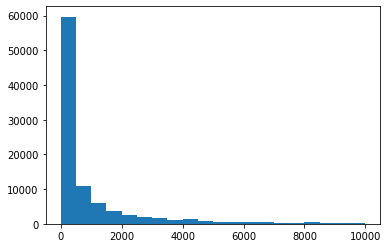

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df[df['num'] < 10000]['num'], bins = 20)
plt.show()

**Text cleaning and TOKENIZATION**
Before we follow with the remaining EDA, let's add badwords count to the pack. To do so, let's do some text cleaning. We'll use regular expression and BeautifulSoup library to proceed.

At this step, we will also do the tokenization. Out of many different tokenizers available, a natural choice for any Twitter-oriented project seems to be an NLTK TweetTokenizer.
One of the text cleaning procedure steps will be replacing negations like "isn't" with their base form "is not" etc. We'll see later, if using bigrams that should catch such two-word phrases would add to the model quality.

In [ ]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)

    words = tokenizer.tokenize(letters_only)
    return (" ".join(words)).strip() # we return a string, not tokens, as most models (tfidf, BERT) require str values as an input

df['processed'] = df['text'].apply(lambda x: tweet_cleaner_updated(x)) 

In [ ]:
df.head()

,date,text,user,num,at,hash,len,links,expert,processed
0,2022-09-01 23:59:54+00:00,@SenatorWicker @CNN @jimsciutto Please send 20...,ArtemiyMoroz,105,3,1,80,0,0,please send more himars to ukraine urgently
1,2022-09-01 23:59:47+00:00,"@Der_Parrot If anything, I see vast potential ...",AdrianEMoser,0,1,0,287,0,0,if anything i see vast potential in creating j...
2,2022-09-01 23:59:47+00:00,"the whos feeding the sheep, this probably goes...",werchenz,107,0,0,270,0,0,the whos feeding the sheep this probably goes ...
3,2022-09-01 23:59:46+00:00,look you too can support Nazis in Ukraine\njus...,vandman777,2968,0,0,110,1,0,look you too can support nazis in ukraine just...
4,2022-09-01 23:59:46+00:00,Create a false pandemic instilling fear &amp; ...,thelastpers0n,37,0,0,307,1,0,create a false pandemic instilling fear confor...


Let's add a badwords count to the dataframe.

In [ ]:
with open('/content/drive/MyDrive/Python_data/badwords.txt') as f:
    lines = f.readline()

badwords = lines.split(',')

def badwords_count(text):
    try:
        text = text.split()
        return len([word for word in text if word in badwords])
    except:
        return 0

df['badwords'] = df['processed'].apply(lambda x: badwords_count(x))

We drop a 'date' column just for the convenience of printing all informative columns in df.head()

In [ ]:
df.drop(['date'], inplace = True, axis = 1)

In [ ]:
df.head()

,text,user,num,at,hash,len,links,expert,processed,badwords
0,@SenatorWicker @CNN @jimsciutto Please send 20...,ArtemiyMoroz,105,3,1,80,0,0,please send more himars to ukraine urgently,0
1,"@Der_Parrot If anything, I see vast potential ...",AdrianEMoser,0,1,0,287,0,0,if anything i see vast potential in creating j...,0
2,"the whos feeding the sheep, this probably goes...",werchenz,107,0,0,270,0,0,the whos feeding the sheep this probably goes ...,0
3,look you too can support Nazis in Ukraine\njus...,vandman777,2968,0,0,110,1,0,look you too can support nazis in ukraine just...,0
4,Create a false pandemic instilling fear &amp; ...,thelastpers0n,37,0,0,307,1,0,create a false pandemic instilling fear confor...,0


At this point, I made an assumption that some categorization of the 'at count', 'hash count', 'links count' and 'badwords count' values would make a model less noisy.

All values exceeding 3 in these columns were cut to 3. A number of tweets with more than 3 hashes or badwords is extremely low and we can treat these values as outliers. Not to make this notebook too long, I will not dive deeper into this to prove it makes sense.

In [ ]:
df['at'] = df['at'].apply(lambda x: 3 if x >=3 else x)
df['hash'] = df['hash'].apply(lambda x: 3 if x >=3 else x)
df['links'] = df['links'].apply(lambda x: 3 if x >=3 else x)
df['badwords'] = df['badwords'].apply(lambda x: 3 if x >=3 else x)

And some final check for the integrity of the dataset to avoid any indexing issues in the following steps.

In [ ]:
print(df.isna().sum())
df.drop_duplicates(inplace = True)
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)
print(f'Number of unique, non-null records: {df.shape[0]}.')

text         0
user         0
num          0
at           0
hash         0
len          0
links        0
expert       0
processed    0
badwords     0
dtype: int64
Number of unique, non-null records: 99732.


The difference in a number of records (99.992 after loading a dataset and 99.732 after its cleaning) comes from the fact, that we dropped duplicates after dropping a "date" column. It looks like 260 tweets were resent by the same user with the same text body at different date. They seemed "unique" only as long as a "date" column was in place.

Now, as the processing is finished, let's save a processed file for the future use.

In [ ]:
df.to_csv('/content/drive/MyDrive/Python_data/processed_tweets.csv', index = False)

NameError: ignored

In [ ]:
df.dropna(inplace = True)
df.reset_index(inplace = True)

In [ ]:
df.isna().sum()

index        0
text         0
user         0
num          0
at           0
hash         0
len          0
links        0
expert       0
processed    0
badwords     0
dtype: int64

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python_data/processed_tweets.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
print(df.shape)

(99731, 11)


In [ ]:
df.head()

,index,text,user,num,at,hash,len,links,expert,processed,badwords
0,0,@SenatorWicker @CNN @jimsciutto Please send 20...,ArtemiyMoroz,105,3,1,80,0,0,please send more himars to ukraine urgently,0
1,1,"@Der_Parrot If anything, I see vast potential ...",AdrianEMoser,0,1,0,287,0,0,if anything i see vast potential in creating j...,0
2,2,"the whos feeding the sheep, this probably goes...",werchenz,107,0,0,270,0,0,the whos feeding the sheep this probably goes ...,0
3,3,look you too can support Nazis in Ukraine\njus...,vandman777,2968,0,0,110,1,0,look you too can support nazis in ukraine just...,0
4,4,Create a false pandemic instilling fear &amp; ...,thelastpers0n,37,0,0,307,1,0,create a false pandemic instilling fear confor...,0


**CountVectorization**
Count vectorization usually produces weaker resuluts than TF-IDF vectorization, but we'll use Count vectorizer to make some analysis on which words occure more often in "expert" and "non-expert" tweets. That should tell us a little bit about a nature of our "project".

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

Below a smart snipped of a code that I copied from some medium.com article. Does the job to create a DataFrame with each word count separately for "expert" and "non expert" words.

In [ ]:
cv = CountVectorizer(stop_words = 'english')
cv.fit(df['processed'])

cv_pos = cv.transform(df[df['expert'] == 1]['processed'])
cv_neg = cv.transform(df[df['expert'] == 0]['processed'])

pos_tf = np.sum(cv_pos,axis=0)
neg_tf = np.sum(cv_neg,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
freq = pd.DataFrame([neg,pos],columns=cv.get_feature_names_out()).transpose()
freq.columns = 'not expert'.split() # column name 'not' for a non-expert, just to make it shorter

In [ ]:
freq.head(10)

,not,expert
aa,23,1
aaa,3,0
aaaa,2,0
aaaaaaagh,1,0
aaaand,2,0
aaah,1,0
aaand,2,0
aahhh,2,0
aam,1,0
aand,1,0


Before we begin to compare both columns, let's do a couple of simple data manipulations:


1.   Let's bring the values of a "not expert" column to the same base as an "expert" column by dividng these values by a denominator len(expert) / len(not expert). It will make comparisions more intuitive. I also rounded the values.
2.   Let's add a 'total' count
3. I also removed rows with a 'total' equal to zero (low 'not expert' values after dividing by a denominator and rounding were flattened to zero, which doesn't really matter - these were words of marginal analitic worth, like 'aa' and similar 



In [ ]:
denominator = len(df[df['expert'] == 1]) / len(df[df['expert'] == 0])

freq['not'] = (freq['not'] * denominator).round().astype('int32')
freq['total'] = freq.sum(axis = 1)
freq.drop(freq[freq['total'] == 0].index, inplace = True) # pozbywamy się tych, gdzie total = 0

In [ ]:
freq.sort_values('total', ascending = False).head(20)

,not,expert,total
ukraine,6882,6865,13747
russia,1863,2361,4224
war,1156,1371,2527
russian,866,1309,2175
putin,765,1029,1794
people,510,323,833
ukrainian,283,464,747
just,463,278,741
world,276,438,714
like,430,266,696


As values are denominated to the same base, we can easily compare them. At first sight we see (as an example) that experts refer to Russia much more often, than ordinary users. We also see much more reference to China or nuclear threat.

And the most interesting part. Let's find words that appear in 'expert' and 'not expert' columns much more often than in the opposite one.
To do so, we'll add two columns:
'expert_rate' - a share of all word occurances in 'expert' tweets. The higher the value, to more this word is biased towards 'expert' tweets. Value 1.0 means this words occurs only in 'expert' tweets.
Let's take a look at top 20 'expert' words. We dropped all words with fewer occurances than 10 in a dataset as irrelevant.

In [ ]:
freq['expert_rate'] = freq['expert'] / freq['total']
freq['not_expert_rate'] = freq['not'] / freq['total']

In [ ]:
freq[freq['total'] > 10].sort_values('expert_rate', ascending = False).head(20)

,not,expert,total,expert_rate,not_expert_rate
nr,0,11,11,1.000000,0.000000
wtpblue,0,13,13,1.000000,0.000000
vermaut,0,54,54,1.000000,0.000000
demvoice,0,17,17,1.000000,0.000000
mostshared,0,12,12,1.000000,0.000000
mostliked,0,11,11,1.000000,0.000000
riskmap,0,17,17,1.000000,0.000000
submitted,0,15,15,1.000000,0.000000
retrospective,0,18,18,1.000000,0.000000
twitters,0,13,13,1.000000,0.000000


As we can see, these are mostly not "normal" words. Let's take an example of "strongertogether" which occurs as much as 196 in expert tweets and only once in a 'not expert' tweet. It is a popular hashtag to support Ukraine. Sometimes it is written without a # sign, so it was not filtered and remained in the tweets body.

This tells us a lot about the nature of this project. Some words, strongly incriminating expert/non-expert status, may be of a temporal nature. Popular hash tags may disappear after a few weeks and their value for a model may diminish. The other may come in their place. It's something different to kaggle contests and we must remember about this in real world project.

In [ ]:
freq[freq['total'] > 10].sort_values('not_expert_rate', ascending = False).head(20)

,not,expert,total,expert_rate,not_expert_rate
peoples,11,0,11,0.000000,1.000000
ukrainianarmy,22,0,22,0.000000,1.000000
ruzzia,16,1,17,0.058824,0.941176
thats,15,1,16,0.062500,0.937500
dude,15,1,16,0.062500,0.937500
translation,13,1,14,0.071429,0.928571
lmao,13,1,14,0.071429,0.928571
im,13,1,14,0.071429,0.928571
ukrainewarnews,12,1,13,0.076923,0.923077
ur,11,1,12,0.083333,0.916667


Now let's come back to our engineered features - at count, hash count, link count and badwords count. Let's see if they differentiate the classes.

We start with tweet length.
As some tweets are very long, for the sake of this plot we'll treat them as outliers and drop all tweets longer than 400 chars (there are less than 500 such tweets in our dataframe).

In [ ]:
df400 = df[df['len'] < 400]

As some users have millions of followers, we'll plot a scatter with a followersCount (we call it 'num' in our dataset) on a log scale.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


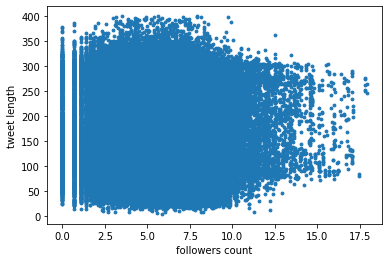

In [ ]:
plt.scatter(np.log(df400['num']), df400['len'], s = 8)
plt.xlabel('followers count')
plt.ylabel('tweet length')
plt.show()

No clear pattern has emerged. We will get the same with histpolot or boxplot or measure of correlation - no clear relationship. Tweet length is not a statistically significant feature for our project.

In a next step, we'll take a look at 'at', 'hash', 'links' and 'badwords' features. All histograms below are normalized so that expert / non-expert counts are equalized.

In [ ]:
def print_col_hist(COL):
    bins = len(df[COL].value_counts())
    sns.displot(df, x = COL, hue = "expert", stat = "density", common_norm = False, bins = bins,
                shrink = 0.7, discrete = True, legend = False)
    plt.xticks(np.arange(4))
    plt.legend(labels = ['expert', 'not expert'])
    plt.show()

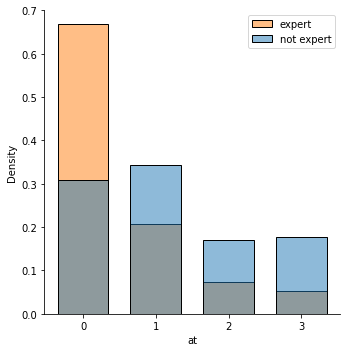

In [ ]:
print_col_hist('at')

We see non-experts use '@name' much more often than experts. Looks like a significant feature.

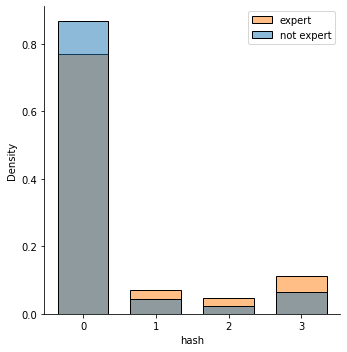

In [ ]:
print_col_hist('hash')

There are much fewer hashes than @ in our tweets, but if they appear, we see them much more often in experts' tweets.

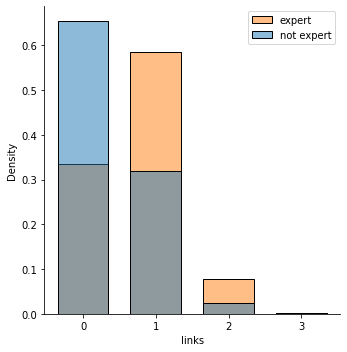

In [ ]:
print_col_hist('links')

Again - experts link to the websites much more often than non-experts.

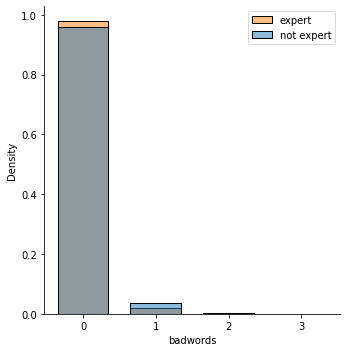

In [ ]:
print_col_hist('badwords')

Honestly, there are much fewer badwords in our tweets than I expected, but our intuition that if used, they would appear more often in non-expert tweets proves to be true.

**BUILDING A MODEL**

It's high time to build our model.
Before we dive deep into exploring vocabulary, let's build a base model using only our engineered features - at, links, hash and badwords count.

We'll use four simple models:

*   Logistic Regression
*   Lasso
*   Ridge
*   Naive Bayes

We'll test all of them on a 5-fold StratifiedKFold.


**Choosing metrics**
Before we move forward with the models (wich are very basic and you'll learn nothing new here, honestly), it's time to take a look at the metrics.

Our dataset is very unbalanced - just to remind - only 6,8% of our tweets come from experts.

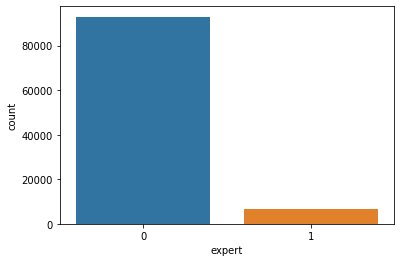

In [ ]:
sns.countplot(data = df, x = 'expert')

That makes accuracy a very weak and misleading metric, of course. Just by labelling each record as "not expert" we could reach almost 93% accuracy.

A natural choice of metrics for imbalanced datasets are precision, recall and their combination called F1.

But here really interesting things begin. Let's begin with a LogisticRegression model and F1 as a metric.

In [ ]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
cols = 'at hash links badwords'.split()
X = df[cols] # feature scaling with any Scaler not necessary for linear models nor for Naive Bayes
y = df['expert']

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)

In [ ]:
model = LogisticRegression()
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

Let's see the results. What's the distribution of classes in our ypreds array.

In [ ]:
unique, counts = np.unique(ypreds, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 19947]]


It looks like our model predicted all values as "not expert".
It resulted in a confusion matrix and F1 measures like below.

In [ ]:
print(confusion_matrix(ytest, ypreds))

[[18559     0]
 [ 1388     0]]


In [ ]:
print(f1_score(ytest, ypreds))

0.0


The problem is in inbalanced nature of the dataset.
Our model.predict() method uses as a default a 0.5 threshold to divide a dataset to the classes in a binary classification.

There are a couple of methods to deal with this challenge. My favourite one is at the same time the simplest. In such a case I always choose brute force. A function below checks F1 metric for all thresholds in a range from 0.01 to 0.99 and picks the one with the highest metric.

In [ ]:
ypreds_proba = model.predict_proba(xtest)

In [ ]:
ypreds_temp = np.zeros(ypreds.shape[0])

f1scores = []
for t in np.arange(0.01, 1, 0.01):
    ypreds_temp = np.where(ypreds_proba[:, 0] > t, 0, 1)
    f1 = f1_score(ytest, ypreds_temp)
    f1scores.append((t, f1))

f1scores is a list of tuples. Each tuple contains a threshold level 't' and an F1 metric for a given threashold.

Let's see how it looks like on a plot.

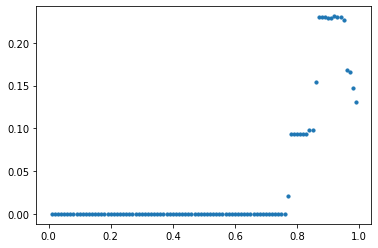

In [ ]:
f1scores = pd.DataFrame(f1scores)
f1scores.columns = 'thresh f1'.split()
threshold = f1scores.loc[f1scores['f1'].idxmax(), 'thresh']
max_f1 = f1scores['f1'].max()

plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 1], s = 10)

In [ ]:
print(f"Best F1 equals {max_f1:.3f} at a threshold {threshold}")

Best F1 equals 0.231 at a threshold 0.92


That's interesting - we reached F1 0.23 at a threshold 0.92!
That is far from good yet, but it's so much more than 0.00 at a 0.5 threshold :-)
We can see on a plot any positive F1 values begin around 0.75 threshold. We'll observe the same with all other models we'll test in this notebook.

Let's try it on a couple of models with a StratifiedKFold

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

In [ ]:
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    BernoulliNB(),
    MultinomialNB(),
]

all_models = []
for model in models:
    model_result = {}
    fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)
    best_f1 = []

    for i, (trainidx, testidx) in enumerate(fold.split(X, y)):
        xtrain, ytrain = X[trainidx], y[trainidx]
        xtest, ytest = X[testidx], y[testidx]
        f1scores = []

        model = model
        model.fit(xtrain, ytrain)
        ypreds_proba = model.predict_proba(xtest)
        ypreds_temp = np.zeros(ypreds_proba.shape[0])

        for t in np.arange(0.01, 1, 0.01):
            ypreds_temp = np.where(ypreds_proba[:, 0] > t, 0, 1)
            f1 = f1_score(ytest, ypreds_temp)
            f1scores.append((t, f1))


        f1scores_df = pd.DataFrame(f1scores)
        f1scores_df.columns = 'thresh f1'.split()
        threshold = f1scores_df.loc[f1scores_df['f1'].idxmax(), 'thresh']
        max_f1 = f1scores_df['f1'].max()
        best_f1.append(max_f1)


    model_result['model'] = model
    model_result['bestf1'] = np.mean(best_f1)
    all_models.append(model_result)
    print(f"Best F1 result for {model} is {np.mean(best_f1):.3f}")


all_models_df = pd.DataFrame(all_models)
print('\n')
print((all_models_df.set_index('model')))

Best F1 result for LogisticRegression() is 0.228
Best F1 result for DecisionTreeClassifier() is 0.233
Best F1 result for BernoulliNB() is 0.227
Best F1 result for MultinomialNB() is 0.225


                            bestf1
model                             
LogisticRegression()      0.228308
DecisionTreeClassifier()  0.233300
BernoulliNB()             0.227033
MultinomialNB()           0.225409


All models produce roughtly the same best F1 result from the engineered features. I doubt more can be squeezed out of these. Let's move forward to the tweets' vocabulary!

**TFIDF**

We will explore three variants:

*   TFIDF with ngrams (1,1) to (1, 3) on a LogisticRegression and NaiveBayes models
*   TFIDF with grams (1,1) to (1, 3) chi2 selection on a LogisticRegresion and NaiveBayes model
*   TFIDF with chi2 selection and engineered features on a Keras model

Our tests showed removing stopwords has a... negative impact on a result, so we'll keep stopwords in a vectorized vocabulary.

I had to reduce max_features to 2000 due to memory issues.
With max_features = 5000 F1 values would be around 0.01-0.02 higher.

For simplicity we dropped kfold verification and only applied train/test split once.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
y = df['expert']
models = [
    LogisticRegression(),
    MultinomialNB(),
    BernoulliNB()
]

all_results = []
for model in models:
    for n in range(1, 4):
        vectorizer = TfidfVectorizer(max_features = 2000, ngram_range = (1, n))
        X = vectorizer.fit_transform(df['processed'])
        X = X.toarray()
        results_dict = {}

        xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8)
        model.fit(xtrain, ytrain)
        ypreds = model.predict(xtest)
        # print(classification_report(ytest, ypreds))

        # f1_score(ytest, ypreds)

        ypreds_proba = model.predict_proba(xtest)

        # unique, counts = np.unique(ypreds, return_counts=True)
        # print(np.asarray((unique, counts)).T)

        ypreds_temp = np.zeros(ypreds.shape[0])

        f1scores = []
        for t in np.arange(0, 1, 0.01):
            ypreds_temp = np.where(ypreds_proba[:, 0] > t, 0, 1)
            f1 = f1_score(ytest, ypreds_temp)
            f1scores.append((t, f1))

        f1scores = pd.DataFrame(f1scores)
        f1scores.columns = 'thresh f1'.split()
        threshold = f1scores.loc[f1scores['f1'].idxmax(), 'thresh'] # threshold przy którym f1 ma max
        max_f1 = f1scores['f1'].max()

        # plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 1])
        # plt.show()
        print(f"Best F1 score for model {model} for ngram 1-{n} is {max_f1:.3f}")
        results_dict['model'] = model
        results_dict['ngram'] = '1, ' + str(n)
        results_dict['best_thresh'] = threshold
        results_dict['f1'] = max_f1
        all_results.append(results_dict)

print('\n')
all_models_df = pd.DataFrame(all_results)
print(all_models_df)

Best F1 score for model LogisticRegression() for ngram 1-1 is 0.267
Best F1 score for model LogisticRegression() for ngram 1-2 is 0.267
Best F1 score for model LogisticRegression() for ngram 1-3 is 0.262
Best F1 score for model MultinomialNB() for ngram 1-1 is 0.273
Best F1 score for model MultinomialNB() for ngram 1-2 is 0.245
Best F1 score for model MultinomialNB() for ngram 1-3 is 0.270
Best F1 score for model BernoulliNB() for ngram 1-1 is 0.274
Best F1 score for model BernoulliNB() for ngram 1-2 is 0.263
Best F1 score for model BernoulliNB() for ngram 1-3 is 0.269


                  model ngram  best_thresh        f1
0  LogisticRegression()  1, 1         0.84  0.267481
1  LogisticRegression()  1, 2         0.85  0.267408
2  LogisticRegression()  1, 3         0.84  0.261533
3       MultinomialNB()  1, 1         0.87  0.273246
4       MultinomialNB()  1, 2         0.88  0.244918
5       MultinomialNB()  1, 3         0.88  0.269793
6         BernoulliNB()  1, 1         0.68  0.27379

With TFIDF, differences between models are rather insignificant and it's possible that with another train/test split the results would be slightly differnt. Bigrams and trigrams do not add value.

**TFIDF wich chi2 vocabulary word selection**
Let's select top 1000 words with the strongest association with the labelled classes.
Again - we will use rather train_test_split than kfold for the speed.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python_data/processed_tweets.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
print(df.shape)
y = df['expert']

(99731, 11)


In [ ]:
temp_vectorizer = TfidfVectorizer()
X_ = temp_vectorizer.fit_transform(df['processed'])
n_features=1000 # we'll keep 1000 best words in our vocabulary
chi2score = chi2(X_,y)[0]
wscores = zip(temp_vectorizer.get_feature_names_out(), chi2score)
wchi2 = sorted(wscores, key = lambda x:x[1])
topchi2 = wchi2[-n_features:]
labels = [t for t, ch in topchi2]
vectorizer = TfidfVectorizer(vocabulary=labels)
X = vectorizer.fit_transform(df['processed'])

For the future use in a Keras model, we'll keep a file with top 5000 words, not top 1000 words. We limit the vocab to 1000 words here as with a sparce 5000 column matrix, our model explodes. With Keras, we'll apply a dense embedding matrix, so we can accept 5000 top words.

In [ ]:
textfile = open("/content/drive/MyDrive/Python_data/vocabulary_chi2_5000.txt", "w")
for element in labels:
    textfile.write(element + "\n")
textfile.close()

Let's plot 20 strongest words, with the highest chi2 score.

Text(0.5, 0, '$\\chi^2$')

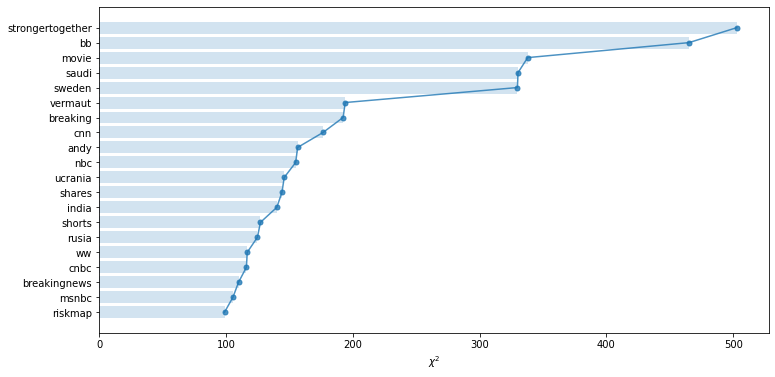

In [ ]:
topchi2_plot = list(zip(*wchi2[-20:]))
x = range(len(topchi2_plot[1]))
labels = topchi2_plot[0]
plt.figure(figsize=(12,6))
plt.barh(x,topchi2_plot[1], align='center', alpha=0.2)
plt.plot(topchi2_plot[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

As we can see, this list is very similar to the list generated with our simple "exptert/non-expert rate" metric produced beforehead.

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, shuffle = True, stratify = y)

In [ ]:
model = LogisticRegression(max_iter = 200)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)
print(classification_report(ytest, ypreds))
print('\n')
print(confusion_matrix(ytest, ypreds))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     18586
           1       0.93      0.06      0.12      1361

    accuracy                           0.94     19947
   macro avg       0.94      0.53      0.54     19947
weighted avg       0.94      0.94      0.91     19947



[[18580     6]
 [ 1275    86]]


With a standard 0.5 threshold, we received F1 score for "expert" guesses. We have a very nice precision - 93% of our guesses "it's an expert" proved to be true. However, recall tells we recognized properly only 6% experts. Together, they sum up to a poor 0.12 F1 score.

Let's see how it performs when we search for the optimal threshold.

In [ ]:
ypreds_proba = model.predict_proba(xtest)
ypreds_temp = np.zeros(ypreds.shape[0])

f1scores = []
for t in np.arange(0, 1, 0.01):
    ypreds_temp = np.where(ypreds_proba[:, 0] > t, 0, 1)
    f1 = f1_score(ytest, ypreds_temp, zero_division = 0)
    prec = precision_score(ytest, ypreds_temp, zero_division = 0)
    rec = recall_score(ytest, ypreds_temp, zero_division = 0)
    f1scores.append((t, f1, prec, rec))

f1scores = pd.DataFrame(f1scores)
f1scores.columns = 'thresh f1 precision recall'.split()
threshold = f1scores.loc[f1scores['f1'].idxmax(), 'thresh'] 
max_prec = f1scores.loc[f1scores['f1'].idxmax(), 'precision'] 
max_rec = f1scores.loc[f1scores['f1'].idxmax(), 'recall'] 
max_f1 = f1scores.loc[f1scores['f1'].idxmax(), 'f1']


print(f"Best F1 {max_f1:.3f} at threshold {threshold} with precision {max_prec:.3f} and recall {max_rec:.3f}")

Best F1 0.305 at threshold 0.87 with precision 0.251 and recall 0.388


Again, with an optimal threshold, we get a significantly better F1 score than with a standard 0.5 threshold. Precision and recall are both far from perfect, but at least they are more balanced now.

Let's try the same with a Naive Bayes model.

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
model = BernoulliNB()
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)
print(classification_report(ytest, ypreds))
print('\n')
print(confusion_matrix(ytest, ypreds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     18586
           1       0.35      0.29      0.31      1361

    accuracy                           0.92     19947
   macro avg       0.65      0.62      0.63     19947
weighted avg       0.91      0.92      0.91     19947



[[17866   720]
 [  972   389]]


It looks much more promising than Logistic Regression!
Let's search for the optimal threshold.

In [ ]:
ypreds_proba = model.predict_proba(xtest)
ypreds_temp = np.zeros(ypreds.shape[0])

f1scores = []
for t in np.arange(0, 1, 0.01):
    ypreds_temp = np.where(ypreds_proba[:, 0] > t, 0, 1)
    f1 = f1_score(ytest, ypreds_temp, zero_division = 0)
    prec = precision_score(ytest, ypreds_temp, zero_division = 0)
    rec = recall_score(ytest, ypreds_temp, zero_division = 0)
    f1scores.append((t, f1, prec, rec))

f1scores = pd.DataFrame(f1scores)
f1scores.columns = 'thresh f1 precision recall'.split()
threshold = f1scores.loc[f1scores['f1'].idxmax(), 'thresh'] 
max_prec = f1scores.loc[f1scores['f1'].idxmax(), 'precision'] 
max_rec = f1scores.loc[f1scores['f1'].idxmax(), 'recall'] 
max_f1 = f1scores.loc[f1scores['f1'].idxmax(), 'f1'] 


print(f"Best F1 {max_f1:.3f} at threshold {threshold} with precision {max_prec:.3f} and recall {max_rec:.3f}")

Best F1 0.323 at threshold 0.58 with precision 0.334 and recall 0.313


Let's see a relationship between threshold and F1 on a plot.

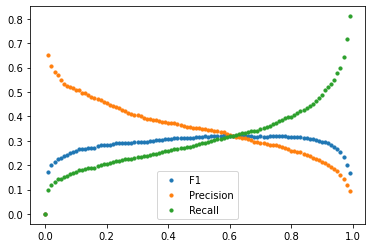

In [ ]:
plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 1], s = 10, label = 'F1')
plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 2], s = 10, label = 'Precision')
plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 3], s = 10, label = 'Recall')
plt.legend()
plt.show()

It's quite intutive. The higher the threshold, the higher the recall (we recognize more experts out of the pool), and the lower the precision (more and more of our guesses "it's an expert!" fail. F1 is maximized somewhere at a point where precision and recall plots cross. Nice exercice to understand this relationship.

**TFIDF summary**

We clearly see chi2 vocabulary selection adds around 0.02-0.03 to our F1 score. Not much, but it's a stable surplus with a smaller vocab, which results in lower memory consumption. Not bad.

**Deep Learning model with KERAS**

Let's try something more sophisticated to check if a deep learning model can outperform basic models like LogisticRegression or Naive Bayes.

Moreover, we'll merge information from two sources - vocabulary and engineered features - in one model. To do this, we'll employ Keras API to concatenate two inputs. We will also apply chi2 word selection, which means we'll put all the best that we have to this pot.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Flatten, Embedding, Dense, Convolution1D, MaxPooling1D, Dropout, Input, Normalization
from keras.layers.merging import concatenate
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import os

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python_data/processed_tweets.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
print(df.shape)
y = df['expert']
X = df['processed']

(99731, 11)


In [ ]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-05, patience=5, verbose=0,
    mode='min', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=3, verbose=0,
    mode='min')

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrate = LearningRateScheduler(scheduler)

In [ ]:
with open('/content/drive/MyDrive/Python_data/vocabulary_chi2_5000.txt') as f:
    words = f.readlines()
chi2_words = [word.replace('\n', '') for word in words]

In [ ]:
print(chi2_words[:20])

['howard', 'retrain', 'ministers', 'govt', 'exploded', 'delightful', 'deeper', 'average', 'backed', 'firm', 'opting', 'superb', 'respectable', 'slope', 'loosing', 'oskil', 'dodger', 'stopfake', 'intertwined', 'krivoy']


Now we'll remove words not in a list chi2_words from our tweets.
In case there was a tweet with no words from a list, we'll put "ukraine" in this place to avoid empty rows.

In [ ]:
vocab_size = len(set(chi2_words))

def choose_chi2(sentence):
    sent = [word for word in sentence.split() if word in chi2_words]
    if len(sent) > 0:
        return " ".join(sent)
    else:
        return "ukraine"

X = X.apply(lambda x: choose_chi2(x))

In [ ]:
for i in range(10):
  print(X[i])

# I don't know why, but when simply prompting print[:10], colab cuts the sentences; surely it can be modified in the options

please send ukraine urgently
if anything see potential in and sweden and in of ukraine an so if they need that ll be sure and
this probably as if we are of from but not or going after lost you get what like ground or like ukraine
look you too can nazis in ukraine just donate now because nazis need money too
pandemic not ones launder billions ukraine by energy crisis lie about being by energy crisis hope no from trump
stand with people of ukraine and russia you military of two countries we are not same
did you see interview with fm she much said fuck we re gonna ukraine no what they or think or or that well enough they don think they have worry
world not ukraine good job russia all peoples without of nuclear of
why would they want him there he all taxpayer dollars ukraine pacific and he look like at
general staff russian troops in southern forces of ukraine strike military facilities on number of strikes carried out with strike aircraft helicopters unmanned


Longest sentence has 45 words.


(array([17311., 20587., 19652., 13230., 11954., 10840.,  4279.,  1661.,
          188.,    29.]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <a list of 10 Patch objects>)

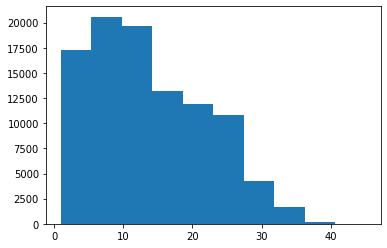

In [ ]:
X_len = [len(x.split()) for x in X]
max_len = max(X_len)
min_len = min(X_len)
print(f"Longest sentence has {max_len} words.")
plt.hist(X_len)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen = max_len)

In [ ]:
print(X[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0  164
   107    1 1044]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   32  166   83  651
     4    2  392    2    4    3    1   52   34   32   12   93   10  154
    17  141    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   16  225   23   32   20
    11    3   24   25    7   41   70   69  178    8   63   30   45  333
    41   45    1]]


In [ ]:
output_dim = 200

def get_model():
    inputs_tfidf = Input(shape = (max_len, ))
    inputs_hand = Input(shape = (5, ))
    # część obsługująca tfidf
    x = Embedding(input_dim = vocab_size, output_dim = output_dim, input_length = max_len, mask_zero = True)(inputs_tfidf)
    x = Convolution1D(filters = 32, kernel_size = 3, padding = 'same', activation= 'relu' , kernel_regularizer = 'l2')(x)
    x = MaxPooling1D(pool_size = 2)(x)
    x = Flatten()(x)
    x = Dense(100, kernel_regularizer = 'l2', activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(5, activation = 'relu')(x)
    # x = Model(inputs = inputs_tfidf, outputs = x)

    # część obsługująca hand
    y = Dense(5, activation = 'relu')(inputs_hand)

    # połączenie modeli
    # combined = concatenate([x, y], axis = 1)
    combined = concatenate([x, y], axis = 1)

    z = Dense(10, activation = 'relu')(combined)
    z = Dropout(0.4)(z)

    outputs = Dense(1, activation = 'sigmoid')(z)
    model = Model(inputs = [inputs_tfidf, inputs_hand], outputs = outputs)

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    return model


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 200)      1000000     ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 45, 32)       19232       ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 22, 32)       0           ['conv1d[0][0]']                 
                                                                                              

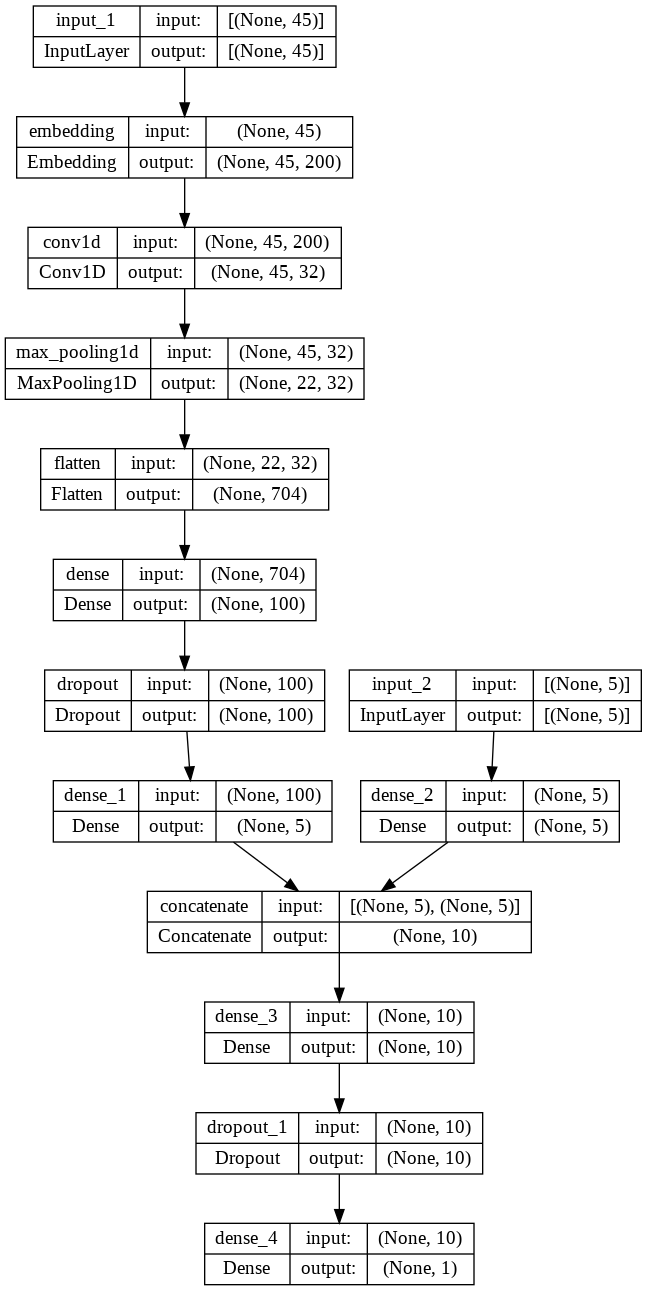

In [ ]:
model = get_model()
print(model.summary())
model_path = '/content/drive/MyDrive/Python_data/model_plot.png'
plot_model(model, to_file=model_path, show_shapes=True, show_layer_names=True)

In [ ]:
def threhsold_f1(ypreds, ytest):
    ypreds_temp = np.zeros(ypreds.shape[0])

    f1scores = []
    for t in np.arange(0, 1, 0.01):
        ypreds_temp = np.where(ypreds > t, 0, 1)
        f1 = f1_score(ytest, ypreds_temp, zero_division = 0)
        prec = precision_score(ytest, ypreds_temp, zero_division = 0)
        rec = recall_score(ytest, ypreds_temp, zero_division = 0)
        f1scores.append((t, f1, prec, rec))

    f1scores = pd.DataFrame(f1scores)
    f1scores.columns = 'thresh f1 precision recall'.split()
    threshold = f1scores.loc[f1scores['f1'].idxmax(), 'thresh']
    max_f1 = f1scores.loc[f1scores['f1'].idxmax(), 'f1']
    max_prec = f1scores.loc[f1scores['f1'].idxmax(), 'precision']
    max_rec = f1scores.loc[f1scores['f1'].idxmax(), 'recall']

    print('\n')
    print(f"The best {max_f1:.3f} at threshold {threshold} with precision {max_prec:.3f} and recall {max_rec:.3f}")

    plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 1], s = 6, label = 'f1')
    plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 2], s = 6, label = 'precision')
    plt.scatter(f1scores.iloc[:, 0], f1scores.iloc[:, 3], s = 6, label = 'recall')
    plt.legend()
    plt.show()
    return threshold, max_f1, max_prec, max_rec

Epoch 1
624/624 [==============================] - 5s 9ms/step


The best 0.329 at threshold 0.8 with precision 0.331 and recall 0.328


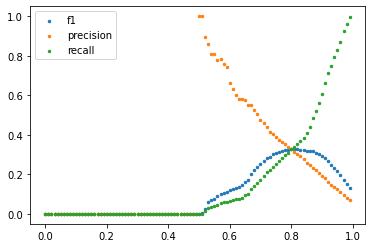

Epoch 2
624/624 [==============================] - 6s 9ms/step


The best 0.346 at threshold 0.86 with precision 0.304 and recall 0.401


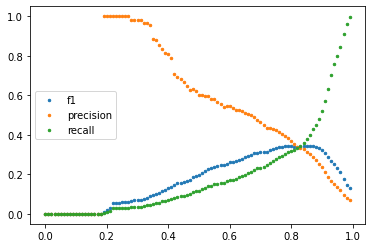

Epoch 3
624/624 [==============================] - 6s 9ms/step


The best 0.326 at threshold 0.86 with precision 0.288 and recall 0.374


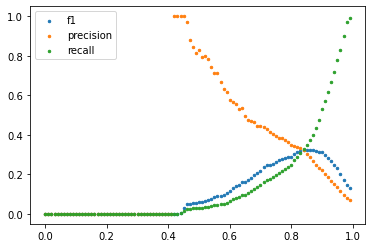

Epoch 4
624/624 [==============================] - 5s 9ms/step


The best 0.344 at threshold 0.8200000000000001 with precision 0.321 and recall 0.371


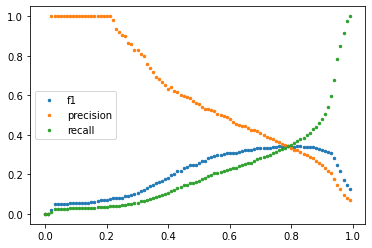

Epoch 5
624/624 [==============================] - 5s 9ms/step


The best 0.339 at threshold 0.8300000000000001 with precision 0.322 and recall 0.357


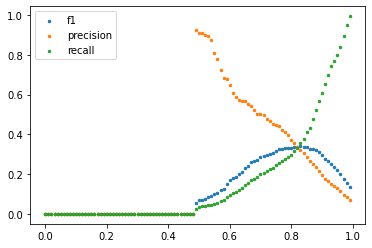

In [ ]:
fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

best_scores = []
for n, (traini, testi) in enumerate(fold.split(X, y)):
    scores = {}
    # to avoid data leakage from train to test sets, we should proceed with the same procedure of chi2-selection
    # for each subset of xtrain before applying transform to xtest
    # but it would be very computationaly expensive for this kind of trivial experiment
    # so I will follow an anti-leakage procedure only on x_rest data, which goes only through MinMaxScaler
    rest_cols = 'at hash len links badwords'.split()
    X_rest = df[rest_cols].to_numpy()

    xtrain, xresttrain, ytrain = X[traini], X_rest[traini], y[traini]
    xtest, xresttest, ytest = X[testi], X_rest[testi], y[testi]

    scaler = MinMaxScaler()
    xresttrain = scaler.fit_transform(xresttrain)
    xresttest = scaler.transform(xresttest)

    print(f"Epoch {n+1}")
    model = get_model()
    model.fit([xtrain, xresttrain], ytrain, epochs = 20, batch_size = 64, validation_split = 0.2, verbose = 0, callbacks = [es, plateau, lrate])

    ypreds = model.predict([xtest, xresttest])
    ypreds = 1 - ypreds
    ypreds_class = np.where(ypreds > 0.5, 0, 1)

    f1_score_fold = f1_score(ytest, ypreds_class)
    threshold_best, max_f1, max_prec, max_rec = threhsold_f1(ypreds, ytest)
    scores = {
        'thresh_best': threshold_best,
        'f1_05': f1_score_fold,
        'f1_best': max_f1,
        'precision_best': max_prec,
        'recall_best': max_rec,
    }
    best_scores.append(scores)

In [ ]:
best_pd = pd.DataFrame(best_scores)
print(best_pd)

   thresh_best     f1_05   f1_best  precision_best  recall_best
0         0.80  0.001468  0.329273        0.330861     0.327700
1         0.86  0.194821  0.345922        0.304299     0.400735
2         0.86  0.060863  0.325656        0.288385     0.373990
3         0.82  0.259155  0.344123        0.320839     0.371051
4         0.83  0.070621  0.338912        0.322495     0.357090


In [ ]:
print(f"Average best F1 is {np.mean(best_pd['f1_best']):.3f}")

Average best F1 is 0.337


It's slightly better than the best F1 we got from LogisticRegression and Naive Bayes, but the difference is as low as 0.01. Not a great deal.

The interesting thing to observe is how different are the best_F1 values and F1 for 0.5 threshold on each fold. Different train set and different keras model weights initialization produced such a variety of results. Very unintuitive and instructive.

This was the best result I managed to produce out of this dataset.

However, it seemed tempting to see whether a state-of-the-art Natural Language Understanding model like BERT could give a better result? Is there any meaningful difference between expert and non-expert tweets that could be discovered by a contextual embedding? Let's try!

**BERT model**

We will use tweets processed with our data-cleaning procedure and TweetTokenizer as an input to BERT Tokenizer rather than raw text.

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 25.7 MB/s 
     |████████████████████████████████| 7.6 MB 41.7 MB/s 
     |████████████████████████████████| 163 kB 42.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Python_data/processed_tweets.csv')
df.dropna(inplace = True)
df.reset_index(inplace = True)
print(df.shape)
y = df['expert']
X = df['processed']

(99731, 11)


We use BERT for tensorflow in this project, so we have to put our data into a tf.data.Dataset object.

In [ ]:
X = X.tolist()
X = tokenizer(X, padding = True, truncation = True, return_tensors = 'tf', max_length = 128)

tf_dataset = tf.data.Dataset.from_tensor_slices((X.data, y))
tf_dataset = tf_dataset.shuffle(100).batch(32)

In [ ]:
test_size = int(len(tf_dataset) * 0.2)
df_valid = tf_dataset.take(test_size)
df_train = tf_dataset.skip(test_size)

import tensorflow_datasets as tfds

ytest = tfds.as_numpy(df_valid)
ylabels = []
for l in ytest:
    ylabels.append(l[1])

ylabels = np.concatenate(ylabels)

We'll use the most popular bert-base-uncased checkpoint from a Huggingface library.

We will also apply a smart learning rate scheduler, as a standard Adam learning rate is way too high for BERT model.

To avoid my Colab notebook breaking, I train my BERT model on 1 epoch only. I tried it with more epochs, but the gain 

In [ ]:
checkpoint = 'bert-base-uncased'
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

num_epochs = 1
num_train_steps = len(df_train) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 0.0, decay_steps = num_train_steps)

opt = Adam(learning_rate = lr_scheduler)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

print(model.summary())
print(f"Num train steps {num_train_steps}")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________
None
Num train steps 2494


In [ ]:
model.fit(df_train, validation_data = df_valid, verbose = 2, epochs = num_epochs)

2494/2494 - 1807s - loss: 0.2267 - accuracy: 0.9325 - val_loss: 0.1934 - val_accuracy: 0.9422 - 1807s/epoch - 724ms/step


In [ ]:
from sklearn.metrics import f1_score, log_loss, accuracy_score, recall_score, precision_score

In [ ]:
ypreds = model.predict(df_valid)

623/623 [==============================] - 128s 206ms/step


In [ ]:
ypreds = ypreds.logits
print(ypreds[:5])

[[ 0.46934596 -1.0455719 ]
 [ 0.78268856 -1.2551302 ]
 [ 1.6793638  -1.7786064 ]
 [ 0.46934596 -1.0455719 ]
 [ 1.2808208  -1.5485667 ]]


In [ ]:
ypreds_soft = tf.math.softmax(ypreds).numpy()
print(ypreds_soft[:5])

[[0.81978893 0.18021111]
 [0.88471097 0.11528903]
 [0.9694679  0.03053206]
 [0.81978893 0.18021111]
 [0.9442434  0.05575662]]


In [ ]:
ypreds_classes = tf.math.argmax(ypreds_soft, axis = -1)

In [ ]:
import matplotlib.pyplot as plt



The best 0.117 at threshold 0.98 with precision 0.062 and recall 1.000


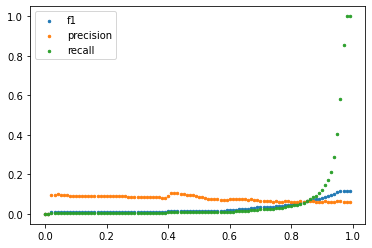

(0.98, 0.11729152894513174, 0.06229935794542536, 1.0)

In [ ]:
threhsold_f1(ypreds_soft[:, 0], ylabels)

It looks like the difference between expert and non-expert tweets does not lie in their "meaning". A contextual embedding from BERT produced by far the worst result. Which doesn't change the fact that generally BERT rocks!

This is the end of the notebook. I hope you had fun :-)